In [ ]:
import cv2
import numpy as np 
from matplotlib import pyplot as plt

img = cv2.imread('/home/robotic/Pictures/1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.bitwise_not(img)

In [85]:
kernel = np.ones((20,20), np.uint8)
img_dil = cv2.dilate(img, kernel, iterations=1)
img_dil = (img_dil*0.5).astype(np.uint8)
img_res = cv2.add(img, img_dil)


kernel1 = np.ones((40,40), np.uint8)
img_dil1 = cv2.dilate(img, kernel1, iterations=1)
img_dil1 = (img_dil1*0.3).astype(np.uint8)
img_res = cv2.add(img_res, img_dil1)

kernel2 = np.ones((80,80), np.uint8)
img_dil2 = cv2.dilate(img, kernel2, iterations=1)
img_dil2 = (img_dil2*0.1).astype(np.uint8)
img_res = cv2.add(img_res, img_dil2)

### DBSCAN

In [180]:
img = cv2.imread('/home/robotic/Pictures/1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.bitwise_not(img)

gray = img
blur = cv2.blur(gray, (3, 3)) # blur the image
ret, thresh = cv2.threshold(blur, 50, 255, cv2.THRESH_BINARY)

In [183]:
np.unique(thresh)

array([  0, 255], dtype=uint8)

In [209]:
from sklearn.cluster import DBSCAN

x = np.where(thresh==255)
X = np.vstack((x[0], x[1])).T

output = DBSCAN(eps=10, min_samples=2).fit(X)

In [210]:
set(output.labels_)
x[1].shape

(18817,)

In [211]:
output.labels_
X.shape

(18817, 2)

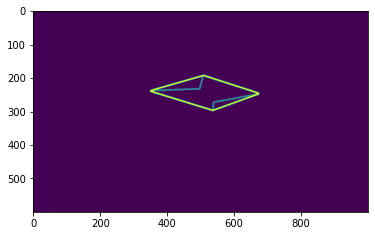

In [303]:
tmp_img = np.zeros((600,1000)).astype(np.uint8)
x1 = X[np.where(output.labels_==1), :][0]
for xy in x1:
    tmp_img[xy[0], xy[1]] = 255

plt.imshow(tmp_img, cmap='gray')

contours, hierarchy = cv2.findContours(tmp_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

img_show = np.zeros((600,1000), dtype=np.uint8)
img_show = cv2.drawContours(img_show, contours, -1, 125, 3)

hull = cv2.convexHull(contours[0])
img_show = cv2.drawContours(img_show, [hull], -1, 255, 3)
plt.imshow(img_show)

In [326]:
import numpy as np 
data = np.load('data.npy', allow_pickle=True)
X = []
rads = np.linspace(0,2*np.pi,1972)
for i,rad in enumerate(rads):
    if data[i] < 2:
        # X.append([data[i], rad])
        X.append([data[i]*np.cos(rad), data[i]*np.sin(rad)])
X = np.array(X)
X.shape

(510, 2)

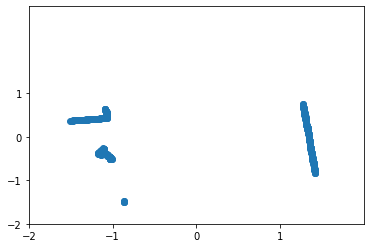

In [343]:
fig, ax = plt.subplots()
ax.scatter(X.T[0], X.T[1])
ax.set(xlim=(-2, 2), xticks=np.arange(-2,2),
       ylim=(-2, 3), yticks=np.arange(-2,2))
plt.show()

In [349]:
output = DBSCAN(eps=0.5, min_samples=5).fit(X).labels_
set(output)

{0, 1, 2, 3}

In [357]:
X.T[0][np.where(output==3)]

array([-0.86988564, -0.8670782 , -0.86851474, -0.86825001, -0.8634516 ])

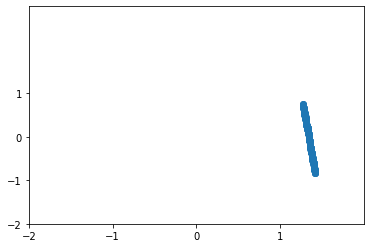

In [353]:
id = 0
fig, ax = plt.subplots()
ax.scatter(X.T[0][np.where(output==id)], X.T[1][np.where(output==id)])
ax.set(xlim=(-2, 2), xticks=np.arange(-2,2),
       ylim=(-2, 3), yticks=np.arange(-2,2))
plt.show()

1
4


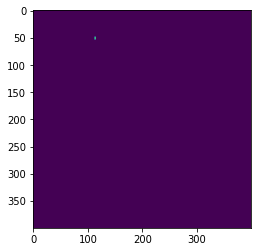

In [511]:
id = 3
scale = 100
x_ = np.int32((X.T[0][np.where(output==id)]+2)*100)
y_ = np.int32((X.T[1][np.where(output==id)]+2)*100)
# x_ = np.int32((X.T[0]+2)*100)
# y_ = np.int32((X.T[1]+2)*100)
img = np.zeros((400,400)).astype(np.uint8)
img[y_,x_] = 255
# plt.imshow(cv2.flip(img, 0), cmap='gray')

kernel = np.ones((5,5))
img = cv2.dilate(img, kernel, iterations=1)
kernel = np.ones((4,4))
img = cv2.erode(img, kernel, iterations=1)

contours, hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print(len(contours))
# img_show = cv2.drawContours(img.copy(), contours, -1, 255, 3)
hull = cv2.convexHull(contours[0])
print(len(hull))
img_show = cv2.drawContours(img.copy(), [hull], -1, 255, 1)
plt.imshow(img_show)

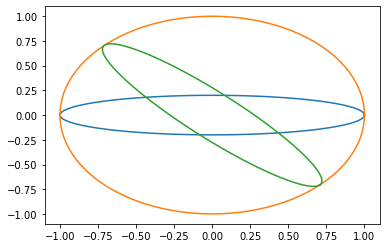

In [31]:
from numpy import pi, cos, sin

a = 1
b = 0.2
t = np.linspace(0, 2*pi, 100)

x = a*cos(t)
y = b*sin(t)

t_rot = pi/4
R_rot = np.array([[cos(t_rot), -sin(t_rot)],[sin(t_rot), cos(t_rot)]])

xy_rot = np.dot(np.vstack((x,y)).T,R_rot)

plt.plot(x,y)
plt.plot(cos(t), sin(t))
plt.plot(xy_rot[:,0], xy_rot[:,1])
plt.show()

In [22]:
xy = np.vstack((x,y)).T